In [1]:
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql import Window
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql.types import FloatType
from pyspark.sql.functions import hour

from fbprophet import Prophet

import os
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

from sklearn import metrics
import seaborn as sns
import time

import os
import ast
import re
from datetime import datetime
from datetime import timedelta
from pyspark.sql import SparkSession
from concurrent.futures import TimeoutError

from fbprophet.serialize import model_to_json, model_from_json

from google.cloud import pubsub_v1

from tqdm.notebook import tqdm
import random

/opt/conda/anaconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Parameters section

LOCATION = "Hamburg"
WEBSITE = "Instagram"
TIME = "day"

# credentials_path = 'weather-based-forecasting-v2-c4bde37656a7.json'
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credentials_path
timeout = 5.0

model_variables = ["Temperature", "Relative Humidity", "Wind Speed", "ds"]

In [3]:
# Auxiliary functions


def get_newest_model_fpath(root_dir="models/"):
    ls = !ls -l --time-style=long-iso models/
    avail_models = [c for c in ls if f"{str.lower(WEBSITE)}_{str.lower(LOCATION)}_{str.lower(TIME)}_model" in c]

    models_dict = {}

    for f in avail_models:
        date, time, name = f.split()[-3:]
        creation_timestamp = datetime.strptime(" ".join([date, time]), "%Y-%m-%d %H:%M")

        models_dict[name] = creation_timestamp

    return os.path.join(root_dir, max(models_dict, key=models_dict.get))


def trim_colnames(df):
    colnames = [re.sub("[^a-zA-Z0-9,]", "", i) for i in df.columns]
    df.columns = colnames
    return df


def assign_class(value, decision_boundaries):
    for _range, _class in decision_boundaries.items():
        # for every pair that you see in table
        if _range[0] <= value < _range[1]:
            return _class
        
        
def predict_class(model, df):
    pred = model.predict(df.toPandas())
    decision_boundaries = {
        (-np.inf, -pred.yhat.quantile(0.9)): -1,
        (-pred.yhat.quantile(0.9), pred.yhat.quantile(0.9)): 0,
        (pred.yhat.quantile(0.9), np.inf): 1,
    }

    pred['pred_class'] = pred.yhat.apply((lambda x: assign_class(x, decision_boundaries)))
    
    return pred[['ds', 'pred_class']]


In [4]:
spark = SparkSession \
    .builder \
    .appName("Time series data analysis with Spark") \
    .config("spark.redis.ssl", "true") \
    .getOrCreate()

In [5]:
# Load pre-trained model from HDFS

TIME = "day"
model_fpath = get_newest_model_fpath()

with open(model_fpath, 'r') as fin:
    m_day = model_from_json(fin.read())  # Load model (test)

#No night model :(
#TIME = "night" 
model_fpath = get_newest_model_fpath()

with open(model_fpath, 'r') as fin:
    m_night = model_from_json(fin.read())  # Load model (test)
    
print(m_day)
print(m_night)

In [6]:
weather_batch = []
trends_batch = []

def weather_callback(message):

    print(f'Received weather message')
    message.ack()
    weather_batch.append(message.data)
    
def trends_callback(message):

    #print(f'Received trends message')
    message.ack()
    trends_batch.append(message.data)

In [7]:
from IPython.display import clear_output
from IPython.display import HTML

HTML('''<script>
var code_show_err = false;
var code_toggle_err = function() {
    var stderrNodes = document.querySelectorAll('[data-mime-type="application/vnd.jupyter.stderr"]')
    var stderr = Array.from(stderrNodes)
    if (code_show_err){
        stderr.forEach(ele => ele.style.display = 'block');
    } else {
        stderr.forEach(ele => ele.style.display = 'none');
    }
    code_show_err = !code_show_err
}
document.addEventListener('DOMContentLoaded', code_toggle_err);
</script>
To toggle on/off output_stderr, click <a onclick="javascript:code_toggle_err()">here</a>.''')

In [8]:
def assign_db_class(value):
    for _range, _class in decision_boundaries.items():
        # for every pair that you see in table
        if _range[0] <= value < _range[1]:
            return _class

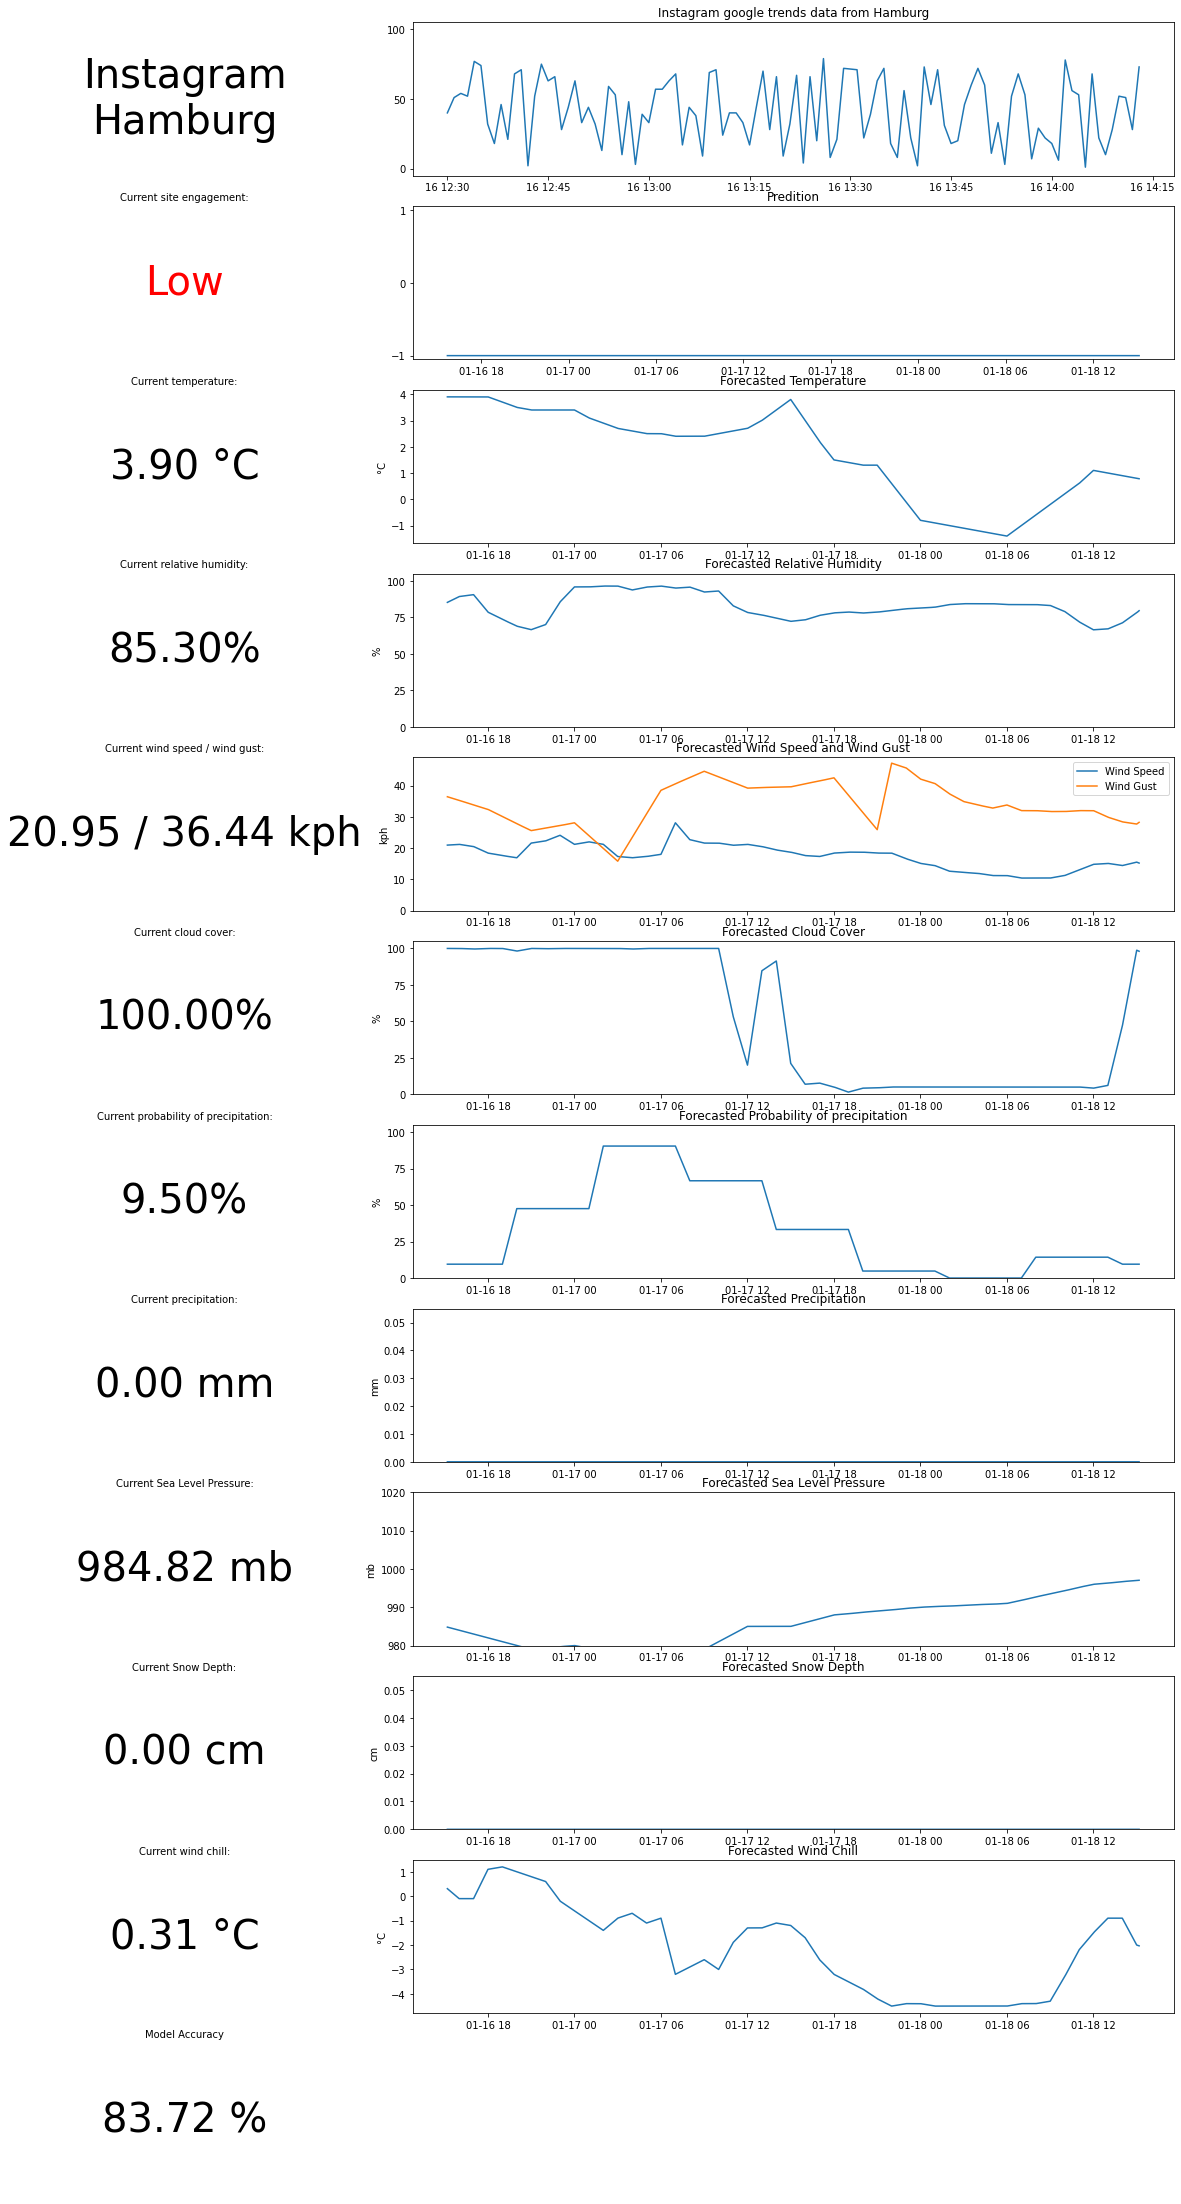

43
Received weather message


INFO:google.api_core.bidi:Thread-ConsumeBidirectionalStream exiting
INFO:google.api_core.bidi:Thread-ConsumeBidirectionalStream exiting
INFO:google.api_core.bidi:Thread-ConsumeBidirectionalStream exiting
INFO:google.api_core.bidi:Thread-ConsumeBidirectionalStream exiting


No new messages - check number: 3.


KeyboardInterrupt: 

In [ ]:
check_count = 0
weather_batch = []
prev_weather_length = len(weather_batch)
prev_trends_length = len(trends_batch)

max_check = 12

plt.ion()
plt.rc('font', size=8)

time_delta = 60*24*2
engagement_map = {-1 : "Low", 0: "Normal", 1 :"High"}
engagement_color_map = {-1 : "Red", 0: "Black", 1 :"Green"}

#trends_df  = pd.DataFrame(columns = ['Date','IndexValue'])
#for i in range(60):
#     trends_df.loc[len(trends_df)] = [(datetime.now() - timedelta(minutes=60-i)).replace(second = 0, microsecond = 0),random.randint(0, 80)]
        
new_plot_iter = 0
y_pred = []


while True:
    if check_count >= max_check: break
    
    time_for_refresh = (datetime.now() + timedelta(minutes=1))
    
    # Weather
    subscriber = pubsub_v1.SubscriberClient()
    
    subscription_path_WD = 'projects/weather-based-forecasting-v2/subscriptions/python_forecast_sub'
    streaming_pull_future_WD = subscriber.subscribe(
        subscription_path_WD, callback=weather_callback
    )

    try:
        streaming_pull_future_WD.result(timeout=5)  
    except TimeoutError:        
        streaming_pull_future_WD.cancel()  
        streaming_pull_future_WD.result()  
    
    #Trends
    subscriber = pubsub_v1.SubscriberClient()
    
    subscription_path_GT = 'projects/weather-based-forecasting-v2/subscriptions/python_trends_sub'
    
    streaming_pull_future_GT = subscriber.subscribe(
            subscription_path_GT, callback=trends_callback
        )

    try:
        streaming_pull_future_GT.result(timeout=5)  
    except TimeoutError:        
        streaming_pull_future_GT.cancel()  
        streaming_pull_future_GT.result()  
    
    if len(weather_batch) > prev_weather_length: and len(trends_batch) > prev_trends_length:

        cnt_diff = len(weather_batch) - prev_weather_length
        
        new_weather_batches = weather_batch[-1:]
        new_trends_batches = trends_batch[-1:]
        
        batch_df = pd.DataFrame()
        plot_df = pd.DataFrame()
        
        
        for weather_obs in new_weather_batches:
            batch_dict = ast.literal_eval(weather_obs.decode('UTF-8'))
            
            batch_obs_list = list(batch_dict.values())
            
            for row in batch_obs_list:
                row_df = pd.DataFrame([row])

                row_df["ds"] = pd.to_datetime(row_df["Date time"])
                rowm_df = row_df[model_variables]
                rowm_df = trim_colnames(rowm_df)
                row_df = trim_colnames(row_df)

                batch_df = pd.concat([batch_df, rowm_df]).reset_index(drop=True)
                plot_df = pd.concat([plot_df, row_df]).reset_index(drop=True)
                    
        batch_dict = ast.literal_eval(trends_batch[-1].decode('UTF-8'))
        #batch_dict = {}
        #Fix for api call ex
        #batch_dict[WEBSITE+'_'+LOCATION] = random.randint(0, 80)
        #batch_dict['date'] = datetime.now().replace(second = 0, microsecond = 0)
        trends_df.loc[len(trends_df)] = [batch_dict['date'],batch_dict[WEBSITE+'_'+LOCATION]]
        trends_df['Date'] = pd.to_datetime(trends_df['Date'],format= '%Y-%m-%d' )

        
        # conversion to Spark dataframe
        batch_DF = spark.createDataFrame(batch_df)
        
        #Day & night split
        day_DF = batch_DF.filter((hour(batch_DF.ds)>= 7 )& (hour(batch_DF.ds) < 23))
        night_DF = batch_DF.filter((hour(batch_DF.ds) < 7 ) | (hour(batch_DF.ds) >= 23))
        
        # Prediction
        pred_day = predict_class(m_day, day_DF)
        pred_night = predict_class(m_night, night_DF)
        
        pred = pd.concat([pred_day,pred_night]).sort_values(by='ds')
        
        decision_boundaries = {
            (-np.inf, -trends_df.IndexValue.quantile(0.9)): -1,
            (-trends_df.IndexValue.quantile(0.9), trends_df.IndexValue.quantile(0.9)): 0,
            (trends_df.IndexValue.quantile(0.9), np.inf): 1
        }
        
        y_true = trends_df.IndexValue.apply(assign_db_class)
        y_pred.append(pred["pred_class"].iloc[0] + 1) 
        y_true = y_true[-len(y_pred):]
        
        accuracy = 100 * sum(np.array(y_true) == np.array(y_pred))/len(y_true)
        
        #Ploting
        plot_df = plot_df.head(time_delta)
        
        figure, axis = plt.subplots(12, 2, figsize=(20, 40), gridspec_kw={'width_ratios': [1, 3]})
        
        axis[0, 1].set_title(WEBSITE + " google trends data from " + LOCATION)
        axis[0, 1].plot(trends_df['Date'],trends_df['IndexValue'].astype(float))
        axis[0, 1].set_ylim(-5,105)
        axis[0, 1].set_yticks([0,50,100])
        
        axis[1, 1].set_title("Predition")
        axis[1, 1].plot(pred["ds"],pred["pred_class"].rolling(30).mean())
        axis[1, 1].set_ylim (bottom=-1.05, top = 1.05)
        axis[1, 1].set_yticks([-1,0,1])
        
        axis[2, 1].set_ylabel("°C")
        axis[2, 1].plot(plot_df["ds"],plot_df["Temperature"].astype(float))
        axis[2, 1].set_title("Forecasted Temperature")
        
        axis[3, 1].set_ylim(0,105)
        axis[3, 1].set_yticks([0,25,50,75,100])
        axis[3, 1].set_ylabel("%")
        axis[3, 1].plot(plot_df["ds"],plot_df["RelativeHumidity"].astype(float))
        axis[3, 1].set_title("Forecasted Relative Humidity")
        
        axis[4, 1].set_ylabel("kph")
        axis[4, 1].plot(plot_df["ds"],plot_df["WindSpeed"].astype(float))
        axis[4, 1].plot(plot_df["ds"],plot_df["WindGust"].astype(float))
        axis[4, 1].legend(['Wind Speed','Wind Gust'])
        axis[4, 1].set_ylim(bottom=0)
        axis[4, 1].set_title("Forecasted Wind Speed and Wind Gust")
        
        axis[5, 1].set_ylim(0,105)
        axis[5, 1].set_yticks([0,25,50,75,100])
        axis[5, 1].set_ylabel("%")
        axis[5, 1].plot(plot_df["ds"],plot_df["CloudCover"].astype(float))
        axis[5, 1].set_title("Forecasted Cloud Cover")
        
        axis[6, 1].set_ylim(0,105)
        axis[6, 1].set_yticks([0,25,50,75,100])
        axis[6, 1].set_ylabel("%")
        axis[6, 1].plot(plot_df["ds"],plot_df["ChancePrecipitation"].astype(float))
        axis[6, 1].set_title("Forecasted Probability of precipitation")
        
        axis[7, 1].set_ylabel("mm")
        axis[7, 1].plot(plot_df["ds"],plot_df["Precipitation"].astype(float))
        axis[7, 1].set_ylim(bottom=0)
        axis[7, 1].set_title("Forecasted Precipitation")
        
        axis[8, 1].set_ylim(980,1020)
        axis[8, 1].set_ylabel("mb")
        axis[8, 1].plot(plot_df["ds"],plot_df["SeaLevelPressure"].astype(float))
        axis[8, 1].set_title("Forecasted Sea Level Pressure")
        
        axis[9, 1].set_ylabel("cm")
        axis[9, 1].plot(plot_df["ds"],plot_df["SnowDepth"].astype(float))
        axis[9, 1].set_ylim(bottom=0)
        axis[9, 1].set_title("Forecasted Snow Depth")
        
        
        axis[10, 1].set_ylabel("°C")
        axis[10, 1].plot(plot_df["ds"],plot_df["WindChill"].astype(float))
        axis[10, 1].set_title("Forecasted Wind Chill")
        
        axis[11, 1].set_axis_off()

        
        
        #Add current Vals
        
        fontsize = 10
        
        _ = axis[0,0].text(0.5,0.5,WEBSITE + '\n' + LOCATION,fontsize=40,horizontalalignment='center',verticalalignment='center')
        axis[0,0].set_axis_off()
        
        _ = axis[1,0].text(0.5,0.5,engagement_map[pred["pred_class"].iloc[0]],fontsize=40,horizontalalignment='center',verticalalignment='center', color = engagement_color_map[pred["pred_class"].iloc[0]])
        axis[1,0].set_axis_off()
        axis[1,0].set_title("Current site engagement:",fontsize = fontsize)
        
        _ = axis[2,0].text(0.5,0.5,"%.2f" % float(plot_df["Temperature"][0]) + ' °C',fontsize=40,horizontalalignment='center',verticalalignment='center')
        axis[2,0].set_axis_off()
        axis[2,0].set_title("Current temperature:",fontsize = fontsize)
        
        _ = axis[3,0].text(0.5,0.5,"%.2f" % float(plot_df["RelativeHumidity"][0]) + '%',fontsize=40,horizontalalignment='center',verticalalignment='center')
        axis[3,0].set_axis_off()
        axis[3,0].set_title("Current relative humidity:",fontsize = fontsize)
        
        _ = axis[4,0].text(0.5,0.5,"%.2f" % float(plot_df["WindSpeed"][0]) + " / "+ "%.2f" % float(plot_df["WindGust"][0]) + ' kph',fontsize=40,horizontalalignment='center',verticalalignment='center')
        axis[4,0].set_axis_off()
        axis[4,0].set_title("Current wind speed / wind gust:",fontsize = fontsize)
        
        _ = axis[5,0].text(0.5,0.5,"%.2f" % float(plot_df["CloudCover"][0]) + '%',fontsize=40,horizontalalignment='center',verticalalignment='center')
        axis[5,0].set_axis_off()
        axis[5,0].set_title("Current cloud cover:",fontsize = fontsize)
        
        _ = axis[6,0].text(0.5,0.5,"%.2f" % float(plot_df["ChancePrecipitation"][0]) + '%',fontsize=40,horizontalalignment='center',verticalalignment='center')
        axis[6,0].set_axis_off()
        axis[6,0].set_title("Current probability of precipitation:",fontsize = fontsize)
        
        _ = axis[7,0].text(0.5,0.5,"%.2f" % float(plot_df["Precipitation"][0]) + ' mm',fontsize=40,horizontalalignment='center',verticalalignment='center')
        axis[7,0].set_axis_off()
        axis[7,0].set_title("Current precipitation:",fontsize = fontsize)
        
        _ = axis[8,0].text(0.5,0.5,"%.2f" % float(plot_df["SeaLevelPressure"][0]) + ' mb',fontsize=40,horizontalalignment='center',verticalalignment='center')
        axis[8,0].set_axis_off()
        axis[8,0].set_title("Current Sea Level Pressure:",fontsize = fontsize)
        
        _ = axis[9,0].text(0.5,0.5,"%.2f" % float(plot_df["SnowDepth"][0]) + ' cm',fontsize=40,horizontalalignment='center',verticalalignment='center')
        axis[9,0].set_axis_off()
        axis[9,0].set_title("Current Snow Depth:",fontsize = fontsize)
        
        _ = axis[10,0].text(0.5,0.5,"%.2f" % float(plot_df["WindChill"][0]) + ' °C',fontsize=40,horizontalalignment='center',verticalalignment='center')
        axis[10,0].set_axis_off()
        axis[10,0].set_title("Current wind chill:",fontsize = fontsize)
        
        _ = axis[11,0].text(0.5,0.5,"%.2f" % accuracy + " %",fontsize=40,horizontalalignment='center',verticalalignment='center')
        axis[11,0].set_axis_off()
        axis[11,0].set_title("Model Accuracy",fontsize = fontsize)
        
        
        plt.savefig("plots/" + WEBSITE + '_' + LOCATION+ str(new_plot_iter))
        clear_output(wait = True)
        plt.show()
        new_plot_iter +=1
        # Saving prediction in HDFS
        ts = str(datetime.now().timestamp()).replace(".", "-")
        path = f"hdfs://cluster-bda2-m/user/root/predictions/forecasts/{ts}.parquet"
        
        spark.createDataFrame(pred).write.parquet(path)
        
        # Update
        prev_weather_length = len(weather_batch)
        prev_trends_length = len(trends_batch)
        
        print(new_plot_iter)
    else:
        check_count += 1
        print(f"No new messages - check number: {check_count}.")
        #time.sleep(60)
    while time_for_refresh > datetime.now():
        time.sleep(1)
    
